In [539]:
import numpy as np

chrom, inter_start_pos, inter_end_pos = '22', 24332998, 24406719

phase_dir = '../phased_ihart_strict'
family_sizes = [3, 4, 5, 6, 7]

ssc_phase_dir = '../phased_ssc_strict'
ssc_family_sizes = [4]

In [540]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                famkey = '.'.join((fam_id, m_id, f_id))
                if famkey not in fam_to_inds:
                    fam_to_inds[famkey] = [m_id, f_id]
                fam_to_inds[famkey].append(child_id)
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [541]:
ihart_family_to_individuals = dict()

for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            ihart_family_to_individuals[family_key] = pieces[1:(1+j)]

ihart_individuals = sorted(sum(ihart_family_to_individuals.values(), []))
ihart_ind_to_index = dict([(x, i) for i, x in enumerate(ihart_individuals)])
                            

In [542]:
ssc_family_to_individuals = dict()

for j in ssc_family_sizes:
    with open('%s/chr.%s.familysize.%d.families.txt' % (ssc_phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            ssc_family_to_individuals[family_key] = pieces[1:(1+j)]

ssc_individuals = sorted(sum(ssc_family_to_individuals.values(), []))
ssc_ind_to_index = dict([(x, i) for i, x in enumerate(ssc_individuals)])
                            

In [543]:
print('ihart families', len(ihart_family_to_individuals))
print('ssc families', len(ssc_family_to_individuals))

ihart families 880
ssc families 516


In [544]:
from collections import defaultdict

# -1: unknown
# 0: no deletions (homref)
# 1: het deletion
# 2: homalt deletion
# 3: either 0 or 1
# 4: either 1 or 2

ihart_deletions = -np.ones((len(ihart_individuals), inter_end_pos-inter_start_pos+1), dtype=np.int8)
gen_to_code = {(-1, -1): -1,
               (-1, 0): 4,
               (-1, 1): 3,
               (0, -1): 4,
               (0, 0): 2,
               (0, 1): 1,
               (1, -1): 3,
               (1, 0): 1,
               (1, 1): 0
              }

for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header

        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            if family_key in ihart_family_to_individuals:
                inds = ihart_family_to_individuals[family_key]
                indices = [ihart_ind_to_index[x] for x in inds]
                state = [int(x) for x in pieces[1:(2+(j*2))]]
                start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]

                if start_pos <= inter_start_pos and inter_end_pos <= end_pos:
                    start_pos, end_pos = inter_start_pos, inter_end_pos
                elif inter_start_pos <= start_pos and end_pos <= inter_end_pos:
                    pass
                elif inter_start_pos <= start_pos and start_pos <= inter_end_pos:
                    end_pos = min(end_pos, inter_end_pos)
                elif inter_start_pos <= end_pos and end_pos <= inter_end_pos:
                    start_pos = max(start_pos, inter_start_pos)
                else:
                    start_pos, end_pos = None, None

                if start_pos is not None:
                    # mom
                    if state[0] == 0 and state[1] == 0:
                        pass
                    else:
                        if len([i for i in range(4, len(state)-1, 2) if state[i]==0]) == 0:
                            state[0] = -1
                        if len([i for i in range(4, len(state)-1, 2) if state[i]==1]) == 0:
                            state[1] = -1
                    ihart_deletions[indices[0], (start_pos-inter_start_pos):(end_pos-inter_start_pos)] = gen_to_code[(state[0], state[1])]

                    # dad
                    if state[2] == 0 and state[3] == 0:
                        pass
                    else:
                        if len([i for i in range(5, len(state)-1, 2) if state[i]==0]) == 0:
                            state[2] = -1
                        if len([i for i in range(5, len(state)-1, 2) if state[i]==1]) == 0:
                            state[3] = -1
                    ihart_deletions[indices[1], (start_pos-inter_start_pos):(end_pos-inter_start_pos)] = gen_to_code[(state[2], state[3])]

                    # children
                    for i in range(2, j):
                        momgen, dadgen = state[(2*i):(2*(i+1))]
                        ihart_deletions[indices[i], (start_pos-inter_start_pos):(end_pos-inter_start_pos)] = gen_to_code[(state[momgen], state[2+dadgen])]

                
                

In [545]:
from collections import defaultdict

# -1: unknown
# 0: no deletions (homref)
# 1: het deletion
# 2: homalt deletion
# 3: either 0 or 1
# 4: either 1 or 2

ssc_deletions = -np.ones((len(ssc_individuals), inter_end_pos-inter_start_pos+1), dtype=np.int8)

for j in ssc_family_sizes:
    with open('%s/chr.%s.familysize.%d.phased.txt' % (ssc_phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header

        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            if family_key in ssc_family_to_individuals:
                inds = ssc_family_to_individuals[family_key]
                indices = [ssc_ind_to_index[x] for x in inds]
                state = [int(x) for x in pieces[1:(2+(j*2))]]
                start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]

                if start_pos <= inter_start_pos and inter_end_pos <= end_pos:
                    start_pos, end_pos = inter_start_pos, inter_end_pos
                elif inter_start_pos <= start_pos and end_pos <= inter_end_pos:
                    pass
                elif inter_start_pos <= start_pos and start_pos <= inter_end_pos:
                    end_pos = min(end_pos, inter_end_pos)
                elif inter_start_pos <= end_pos and end_pos <= inter_end_pos:
                    start_pos = max(start_pos, inter_start_pos)
                else:
                    start_pos, end_pos = None, None

                if start_pos is not None:
                    # mom
                    if state[0] == 0 and state[1] == 0:
                        pass
                    else:
                        if len([i for i in range(4, len(state)-1, 2) if state[i]==0]) == 0:
                            state[0] = -1
                        if len([i for i in range(4, len(state)-1, 2) if state[i]==1]) == 0:
                            state[1] = -1
                    ssc_deletions[indices[0], (start_pos-inter_start_pos):(end_pos-inter_start_pos)] = gen_to_code[(state[0], state[1])]

                    # dad
                    if state[2] == 0 and state[3] == 0:
                        pass
                    else:
                        if len([i for i in range(5, len(state)-1, 2) if state[i]==0]) == 0:
                            state[2] = -1
                        if len([i for i in range(5, len(state)-1, 2) if state[i]==1]) == 0:
                            state[3] = -1
                    ssc_deletions[indices[1], (start_pos-inter_start_pos):(end_pos-inter_start_pos)] = gen_to_code[(state[2], state[3])]

                    # children
                    for i in range(2, j):
                        momgen, dadgen = state[(2*i):(2*(i+1))]
                        ssc_deletions[indices[i], (start_pos-inter_start_pos):(end_pos-inter_start_pos)] = gen_to_code[(state[momgen], state[2+dadgen])]

                
                

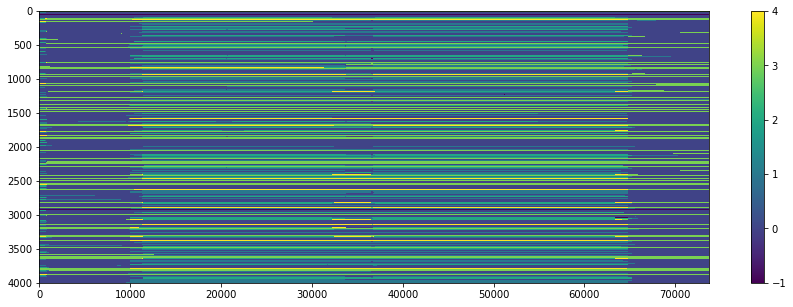

In [546]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))
plt.imshow(ihart_deletions, aspect='auto')
plt.colorbar()
plt.show()

In [547]:
print(ihart_deletions.shape)
print(ssc_deletions.shape)

(3995, 73722)
(2064, 73722)


In [548]:
ihart_is_child = np.zeros((len(ihart_individuals),), dtype=bool)
ihart_is_mother = np.zeros((len(ihart_individuals),), dtype=bool)
ihart_is_father = np.zeros((len(ihart_individuals),), dtype=bool)
for inds in ihart_family_to_individuals.values():
    ihart_is_mother[ihart_ind_to_index[inds[0]]] = True
    ihart_is_father[ihart_ind_to_index[inds[1]]] = True
    for child in inds[2:]:
        ihart_is_child[ihart_ind_to_index[child]] = True
        
        

In [549]:
ssc_is_child = np.zeros((len(ssc_individuals),), dtype=bool)
ssc_is_mother = np.zeros((len(ssc_individuals),), dtype=bool)
ssc_is_father = np.zeros((len(ssc_individuals),), dtype=bool)
for inds in ssc_family_to_individuals.values():
    ssc_is_mother[ssc_ind_to_index[inds[0]]] = True
    ssc_is_father[ssc_ind_to_index[inds[1]]] = True
    for child in inds[2:]:
        ssc_is_child[ssc_ind_to_index[child]] = True
        

All
1835 399
516 516
Males
1419 193
459 229
Females
416 206
50 263


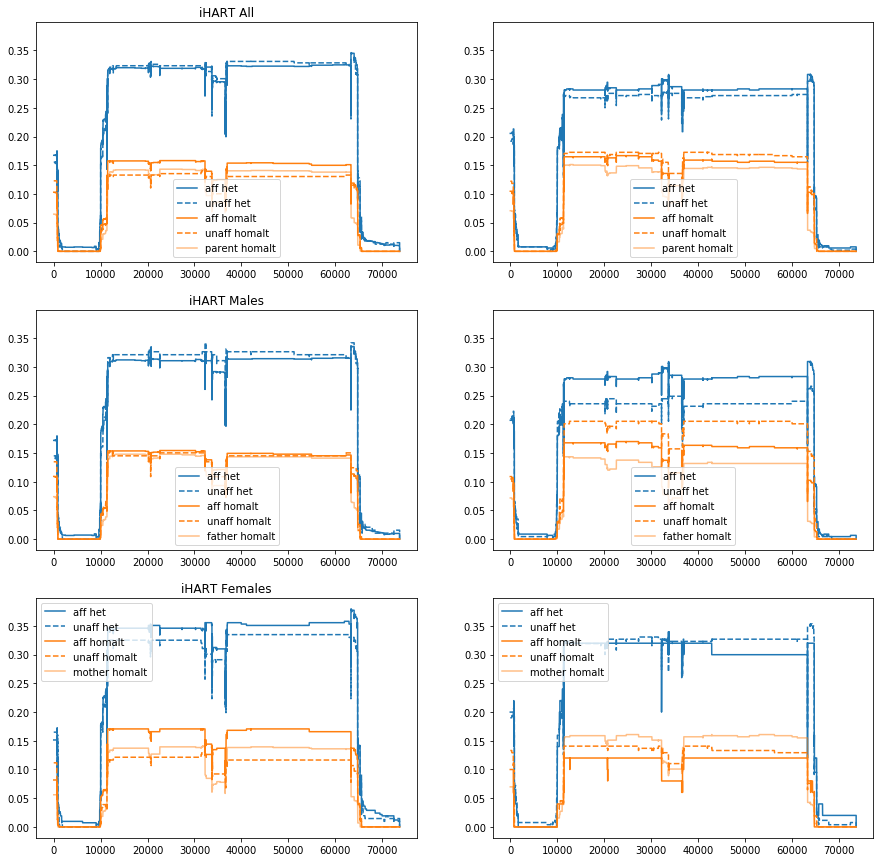

In [550]:
plt.figure(figsize=(15, 15))

ax = plt.subplot(3, 2, 1)
plt.title('iHART All')
ihart_affected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '2' and ihart_is_child[i]]
ihart_unaffected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '1' and ihart_is_child[i]]
ssc_affected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '2' and ssc_is_child[i]]
ssc_unaffected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '1' and ssc_is_child[i]]
print('All')
print(len(ihart_affected_indices), len(ihart_unaffected_indices))
print(len(ssc_affected_indices), len(ssc_unaffected_indices))

p = plt.plot(np.sum(ihart_deletions[ihart_affected_indices, :]==1, axis=0)/len(ihart_affected_indices), label='aff het')
plt.plot(np.sum(ihart_deletions[ihart_unaffected_indices, :]==1, axis=0)/len(ihart_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())
#plt.plot(np.sum(ihart_deletions[~ihart_is_child, :]==1, axis=0)/np.sum(~ihart_is_child), label='parent het', alpha=0.5, color=p[0].get_color())

p = plt.plot(np.sum(ihart_deletions[ihart_affected_indices, :]==2, axis=0)/len(ihart_affected_indices), label='aff homalt')
plt.plot(np.sum(ihart_deletions[ihart_unaffected_indices, :]==2, axis=0)/len(ihart_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.plot(np.sum(ihart_deletions[~ihart_is_child, :]==2, axis=0)/np.sum(~ihart_is_child), label='parent homalt', alpha=0.5, color=p[0].get_color())
plt.legend()

plt.subplot(3, 2, 2, sharey=ax)
p = plt.plot(np.sum(ssc_deletions[ssc_affected_indices, :]==1, axis=0)/len(ssc_affected_indices), label='aff het')
plt.plot(np.sum(ssc_deletions[ssc_unaffected_indices, :]==1, axis=0)/len(ssc_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())
#plt.plot(np.sum(ssc_deletions[~ssc_is_child, :]==1, axis=0)/np.sum(~ssc_is_child), label='parent het', alpha=0.5, color=p[0].get_color())

p = plt.plot(np.sum(ssc_deletions[ssc_affected_indices, :]==2, axis=0)/len(ssc_affected_indices), label='aff homalt')
plt.plot(np.sum(ssc_deletions[ssc_unaffected_indices, :]==2, axis=0)/len(ssc_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.plot(np.sum(ssc_deletions[~ssc_is_child, :]==2, axis=0)/np.sum(~ssc_is_child), label='parent homalt', alpha=0.5, color=p[0].get_color())
plt.legend()

plt.subplot(3, 2, 3, sharey=ax)
plt.title('iHART Males')
ihart_affected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1' and ihart_is_child[i]]
ihart_unaffected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '1' and ihart_is_child[i]]
ssc_affected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1' and ssc_is_child[i]]
ssc_unaffected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '1' and ssc_is_child[i]]
print('Males')
print(len(ihart_affected_indices), len(ihart_unaffected_indices))
print(len(ssc_affected_indices), len(ssc_unaffected_indices))

p = plt.plot(np.sum(ihart_deletions[ihart_affected_indices, :]==1, axis=0)/len(ihart_affected_indices), label='aff het')
plt.plot(np.sum(ihart_deletions[ihart_unaffected_indices, :]==1, axis=0)/len(ihart_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())
#plt.plot(np.sum(ihart_deletions[ihart_is_father, :]==1, axis=0)/np.sum(ihart_is_father), label='father het', alpha=0.5, color=p[0].get_color())

p = plt.plot(np.sum(ihart_deletions[ihart_affected_indices, :]==2, axis=0)/len(ihart_affected_indices), label='aff homalt')
plt.plot(np.sum(ihart_deletions[ihart_unaffected_indices, :]==2, axis=0)/len(ihart_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.plot(np.sum(ihart_deletions[ihart_is_father, :]==2, axis=0)/np.sum(ihart_is_father), label='father homalt', alpha=0.5, color=p[0].get_color())
plt.legend()

plt.subplot(3, 2, 4, sharey=ax)
p = plt.plot(np.sum(ssc_deletions[ssc_affected_indices, :]==1, axis=0)/len(ssc_affected_indices), label='aff het')
plt.plot(np.sum(ssc_deletions[ssc_unaffected_indices, :]==1, axis=0)/len(ssc_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())
#plt.plot(np.sum(ssc_deletions[ssc_is_father, :]==1, axis=0)/np.sum(ssc_is_father), label='father het', alpha=0.5, color=p[0].get_color())

p = plt.plot(np.sum(ssc_deletions[ssc_affected_indices, :]==2, axis=0)/len(ssc_affected_indices), label='aff homalt')
plt.plot(np.sum(ssc_deletions[ssc_unaffected_indices, :]==2, axis=0)/len(ssc_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.plot(np.sum(ssc_deletions[ssc_is_father, :]==2, axis=0)/np.sum(ssc_is_father), label='father homalt', alpha=0.5, color=p[0].get_color())
plt.legend()

plt.subplot(3, 2, 5, sharey=ax)
plt.title('iHART Females')
ihart_affected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '2' and ihart_is_child[i]]
ihart_unaffected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '2' and ihart_is_child[i]]
ssc_affected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '2' and ssc_is_child[i]]
ssc_unaffected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '2' and ssc_is_child[i]]
print('Females')
print(len(ihart_affected_indices), len(ihart_unaffected_indices))
print(len(ssc_affected_indices), len(ssc_unaffected_indices))

p = plt.plot(np.sum(ihart_deletions[ihart_affected_indices, :]==1, axis=0)/len(ihart_affected_indices), label='aff het')
plt.plot(np.sum(ihart_deletions[ihart_unaffected_indices, :]==1, axis=0)/len(ihart_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())
#plt.plot(np.sum(ihart_deletions[ihart_is_mother, :]==1, axis=0)/np.sum(ihart_is_mother), label='mother het', alpha=0.5, color=p[0].get_color())

p = plt.plot(np.sum(ihart_deletions[ihart_affected_indices, :]==2, axis=0)/len(ihart_affected_indices), label='aff homalt')
plt.plot(np.sum(ihart_deletions[ihart_unaffected_indices, :]==2, axis=0)/len(ihart_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.plot(np.sum(ihart_deletions[ihart_is_mother, :]==2, axis=0)/np.sum(ihart_is_mother), label='mother homalt', alpha=0.5, color=p[0].get_color())
plt.legend()

plt.subplot(3, 2, 6, sharey=ax)
p = plt.plot(np.sum(ssc_deletions[ssc_affected_indices, :]==1, axis=0)/len(ssc_affected_indices), label='aff het')
plt.plot(np.sum(ssc_deletions[ssc_unaffected_indices, :]==1, axis=0)/len(ssc_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())
#plt.plot(np.sum(ssc_deletions[ssc_is_mother, :]==1, axis=0)/np.sum(ssc_is_mother), label='mother het', alpha=0.5, color=p[0].get_color())

p = plt.plot(np.sum(ihart_deletions[ssc_affected_indices, :]==2, axis=0)/len(ssc_affected_indices), label='aff homalt')
plt.plot(np.sum(ssc_deletions[ssc_unaffected_indices, :]==2, axis=0)/len(ssc_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.plot(np.sum(ssc_deletions[ssc_is_mother, :]==2, axis=0)/np.sum(ssc_is_mother), label='mother homalt', alpha=0.5, color=p[0].get_color())
plt.legend()

plt.show()

In [551]:
ihart_contingency = np.zeros((inter_end_pos-inter_start_pos+1, 2, 2), dtype=int)
ihart_contingency_f = np.zeros((inter_end_pos-inter_start_pos+1, 2, 2), dtype=int)
ihart_contingency_m = np.zeros((inter_end_pos-inter_start_pos+1, 2, 2), dtype=int)

for inds in ihart_family_to_individuals.values():
    indices = [ihart_ind_to_index[x] for x in inds]
    mom_index, dad_index = indices[:2]
    for child_index, child in zip(indices[2:], inds[2:]):
        a = ((ihart_deletions[mom_index, :]==0) & (ihart_deletions[dad_index, :]==1) & (ihart_deletions[child_index, :]==1)) \
            + ((ihart_deletions[mom_index, :]==1) & (ihart_deletions[dad_index, :]==0) & (ihart_deletions[child_index, :]==1)) \
            + ((ihart_deletions[mom_index, :]==2) & (ihart_deletions[dad_index, :]==1) & (ihart_deletions[child_index, :]==2)) \
            + ((ihart_deletions[mom_index, :]==1) & (ihart_deletions[dad_index, :]==2) & (ihart_deletions[child_index, :]==2))
        
        b = ((ihart_deletions[mom_index, :]==0) & (ihart_deletions[dad_index, :]==1) & (ihart_deletions[child_index, :]==0)) \
            + ((ihart_deletions[mom_index, :]==1) & (ihart_deletions[dad_index, :]==0) & (ihart_deletions[child_index, :]==0)) \
            + ((ihart_deletions[mom_index, :]==2) & (ihart_deletions[dad_index, :]==1) & (ihart_deletions[child_index, :]==1)) \
            + ((ihart_deletions[mom_index, :]==1) & (ihart_deletions[dad_index, :]==2) & (ihart_deletions[child_index, :]==1)) 
        
        aff = int(child_id_to_affected[child] == '2')
        ihart_contingency[:, aff, 1] += a
        ihart_contingency[:, aff, 0] += b
                     
        if child_id_to_sex[child] == '2':
            ihart_contingency_f[:, aff, 1] += a
            ihart_contingency_f[:, aff, 0] += b
        else:
            ihart_contingency_m[:, aff, 1] += a
            ihart_contingency_m[:, aff, 0] += b
                                          

In [552]:
ssc_contingency = np.zeros((inter_end_pos-inter_start_pos+1, 2, 2), dtype=int)
ssc_contingency_f = np.zeros((inter_end_pos-inter_start_pos+1, 2, 2), dtype=int)
ssc_contingency_m = np.zeros((inter_end_pos-inter_start_pos+1, 2, 2), dtype=int)

for inds in ssc_family_to_individuals.values():
    indices = [ssc_ind_to_index[x] for x in inds]
    mom_index, dad_index = indices[:2]
    for child_index, child in zip(indices[2:], inds[2:]):
        a = ((ssc_deletions[mom_index, :]==0) & (ssc_deletions[dad_index, :]==1) & (ssc_deletions[child_index, :]==1)) \
            + ((ssc_deletions[mom_index, :]==1) & (ssc_deletions[dad_index, :]==0) & (ssc_deletions[child_index, :]==1)) \
            + ((ssc_deletions[mom_index, :]==2) & (ssc_deletions[dad_index, :]==1) & (ssc_deletions[child_index, :]==2)) \
            + ((ssc_deletions[mom_index, :]==1) & (ssc_deletions[dad_index, :]==2) & (ssc_deletions[child_index, :]==2))
        
        b = ((ssc_deletions[mom_index, :]==0) & (ssc_deletions[dad_index, :]==1) & (ssc_deletions[child_index, :]==0)) \
            + ((ssc_deletions[mom_index, :]==1) & (ssc_deletions[dad_index, :]==0) & (ssc_deletions[child_index, :]==0)) \
            + ((ssc_deletions[mom_index, :]==2) & (ssc_deletions[dad_index, :]==1) & (ssc_deletions[child_index, :]==1)) \
            + ((ssc_deletions[mom_index, :]==1) & (ssc_deletions[dad_index, :]==2) & (ssc_deletions[child_index, :]==1)) 
        
        
        aff = int(child_id_to_affected[child] == '2')
        ssc_contingency[:, aff, 1] += a
        ssc_contingency[:, aff, 0] += b
                     
        if child_id_to_sex[child] == '2':
            ssc_contingency_f[:, aff, 1] += a
            ssc_contingency_f[:, aff, 0] += b
        else:
            ssc_contingency_m[:, aff, 1] += a
            ssc_contingency_m[:, aff, 0] += b
                                          

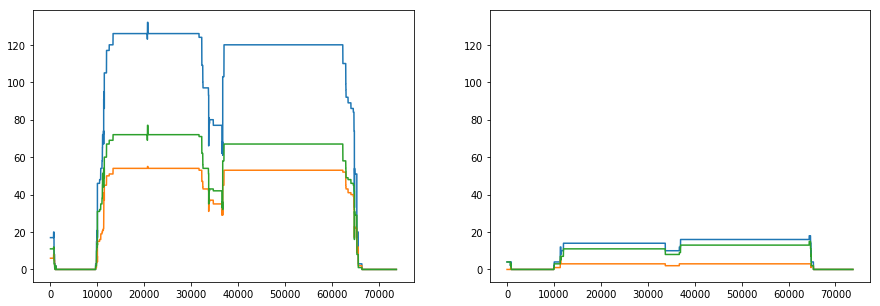

In [527]:
plt.figure(figsize=(15, 5))

ax =plt.subplot(1, 2, 1)
plt.plot(np.sum(ihart_contingency, axis=(1, 2)))
plt.plot(np.sum(ihart_contingency_f, axis=(1, 2)))
plt.plot(np.sum(ihart_contingency_m, axis=(1, 2)))

plt.subplot(1, 2, 2, sharey=ax)
plt.plot(np.sum(ssc_contingency, axis=(1, 2)))
plt.plot(np.sum(ssc_contingency_f, axis=(1, 2)))
plt.plot(np.sum(ssc_contingency_m, axis=(1, 2)))

plt.show()

In [528]:
import scipy.stats

def calc_hypergeometric_pvalue(ct):
    aut_trans, typ_trans, aut_notrans, typ_notrans = ct[1, 1], ct[0, 1], ct[1, 0], ct[0, 0]
    trans_op = typ_trans + aut_trans + aut_notrans + typ_notrans
    trans = typ_trans + aut_trans
    
    if aut_trans/(aut_trans+aut_notrans) > typ_trans/(typ_trans+typ_notrans):
        return 2*scipy.stats.hypergeom.sf(aut_trans, trans_op, aut_trans+aut_notrans, trans) + scipy.stats.hypergeom.pmf(aut_trans, trans_op, aut_trans+aut_notrans, trans)
    else:
        return 2*scipy.stats.hypergeom.cdf(aut_trans, trans_op, aut_trans+aut_notrans, trans)

cached_pvalue = dict()
ihart_pvalues = np.zeros((ihart_contingency.shape[0],))
ihart_pvalues_f = np.zeros((ihart_contingency.shape[0],))
ihart_pvalues_m = np.zeros((ihart_contingency.shape[0],))
ssc_pvalues = np.zeros((ssc_contingency.shape[0],))
ssc_pvalues_f = np.zeros((ssc_contingency.shape[0],))
ssc_pvalues_m = np.zeros((ssc_contingency.shape[0],))

for i in range(ihart_contingency.shape[0]):
    ct = ihart_contingency[i]
    k = tuple(ct.ravel())
    if k not in cached_pvalue:
        if np.all(ct>5):
            cached_pvalue[k] = scipy.stats.chi2_contingency(ct)[1]
        else:
            cached_pvalue[k] = calc_hypergeometric_pvalue(ct)
    ihart_pvalues[i] = cached_pvalue[k]
    
    ct = ihart_contingency_f[i]
    k = tuple(ct.ravel())
    if k not in cached_pvalue:
        if np.all(ct>5):
            cached_pvalue[k] = scipy.stats.chi2_contingency(ct)[1]
        else:
            cached_pvalue[k] = calc_hypergeometric_pvalue(ct)
    ihart_pvalues_f[i] = cached_pvalue[k]
    
    ct = ihart_contingency_m[i]
    k = tuple(ct.ravel())
    if k not in cached_pvalue:
        if np.all(ct>5):
            cached_pvalue[k] = scipy.stats.chi2_contingency(ct)[1]
        else:
            cached_pvalue[k] = calc_hypergeometric_pvalue(ct)
    ihart_pvalues_m[i] = cached_pvalue[k]
    
    ct = ssc_contingency[i]
    k = tuple(ct.ravel())
    if k not in cached_pvalue:
        if np.all(ct>5):
            cached_pvalue[k] = scipy.stats.chi2_contingency(ct)[1]
        else:
            cached_pvalue[k] = calc_hypergeometric_pvalue(ct)
    ssc_pvalues[i] = cached_pvalue[k]
    
    ct = ssc_contingency_f[i]
    k = tuple(ct.ravel())
    if k not in cached_pvalue:
        if np.all(ct>5):
            cached_pvalue[k] = scipy.stats.chi2_contingency(ct)[1]
        else:
            cached_pvalue[k] = calc_hypergeometric_pvalue(ct)
    ssc_pvalues_f[i] = cached_pvalue[k]
    
    ct = ssc_contingency_m[i]
    k = tuple(ct.ravel())
    if k not in cached_pvalue:
        if np.all(ct>5):
            cached_pvalue[k] = scipy.stats.chi2_contingency(ct)[1]
        else:
            cached_pvalue[k] = calc_hypergeometric_pvalue(ct)
    ssc_pvalues_m[i] = cached_pvalue[k]
        

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


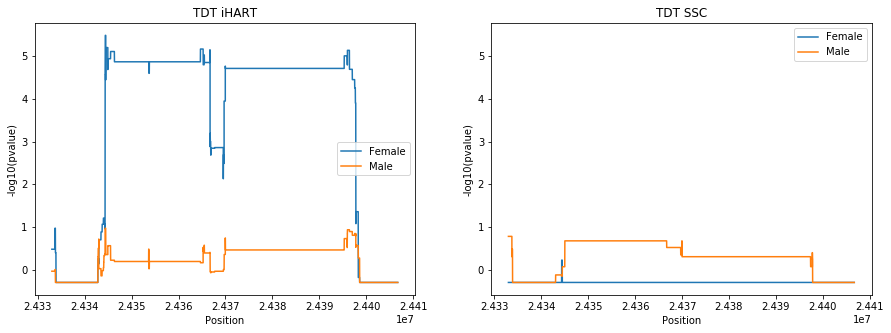

In [529]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.title('TDT iHART')
#plt.plot(range(inter_start_pos, inter_end_pos+1), -np.log10(ihart_pvalues))
plt.plot(range(inter_start_pos, inter_end_pos+1), -np.log10(ihart_pvalues_f), label='Female')
plt.plot(range(inter_start_pos, inter_end_pos+1), -np.log10(ihart_pvalues_m), label='Male')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.legend()

plt.subplot(1, 2, 2, sharey=ax)
plt.title('TDT SSC')
#plt.plot(range(inter_start_pos, inter_end_pos+1), -np.log10(ssc_pvalues))
plt.plot(range(inter_start_pos, inter_end_pos+1), -np.log10(ssc_pvalues_f), label='Female')
plt.plot(range(inter_start_pos, inter_end_pos+1), -np.log10(ssc_pvalues_m), label='Male')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.legend()
plt.show()

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


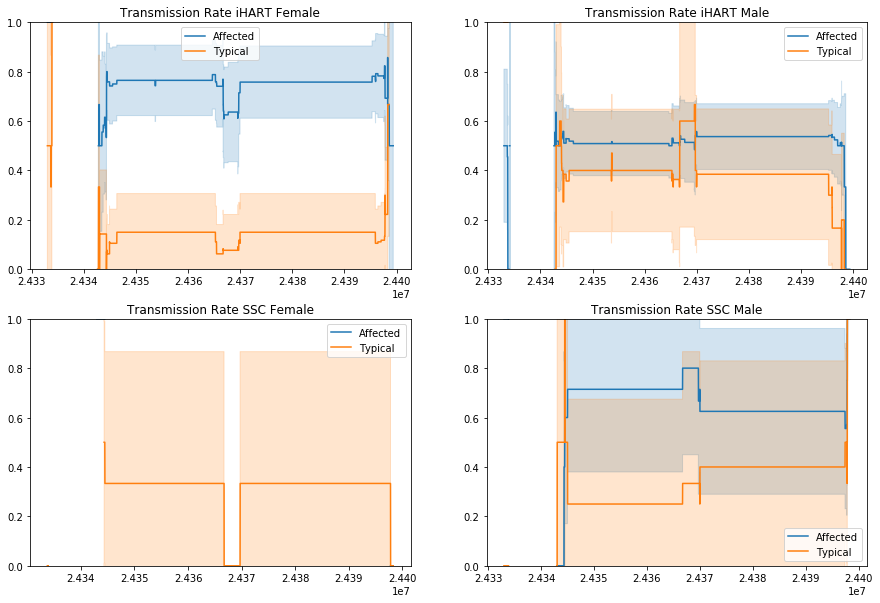

In [530]:
plt.figure(figsize=(15, 10))

def plot_with_error(contingency, label):
    f = contingency[:, 1]/np.sum(contingency, axis=1)
    e = [1.96*np.sqrt(x*(1-x)/n) for x, n in zip(f, np.sum(contingency, axis=1))]
    p = plt.plot(xs, f, label=label)
    plt.fill_between(xs, [x-y for x, y in zip(f, e)], [x+y for x, y in zip(f, e)], color=p[0].get_color(), alpha=0.2)


xs = range(inter_start_pos, inter_end_pos+1)

plt.subplot(2, 2, 1)
plot_with_error(ihart_contingency_f[:, 1, :], label='Affected')
plot_with_error(ihart_contingency_f[:, 0, :], label='Typical')
plt.title('Transmission Rate iHART Female')
plt.ylim([0, 1])
plt.legend()

plt.subplot(2, 2, 2)
plot_with_error(ihart_contingency_m[:, 1, :], label='Affected')
plot_with_error(ihart_contingency_m[:, 0, :], label='Typical')
plt.title('Transmission Rate iHART Male')
plt.ylim([0, 1])
plt.legend()

plt.subplot(2, 2, 3)
plot_with_error(ssc_contingency_f[:, 1, :], label='Affected')
plot_with_error(ssc_contingency_f[:, 0, :], label='Typical')
plt.title('Transmission Rate SSC Female')
plt.ylim([0, 1])
plt.legend()

plt.subplot(2, 2, 4)
plot_with_error(ssc_contingency_m[:, 1, :], label='Affected')
plot_with_error(ssc_contingency_m[:, 0, :], label='Typical')
plt.title('Transmission Rate SSC Male')
plt.ylim([0, 1])
plt.legend()

plt.show()

# Pull genotype data

In [464]:
chrom = '22'
data_dir = '../split_gen_ihart'

# pull families with sequence data
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
with open(sample_file, 'r') as f:
    sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

# use only "cleaned" variants - must be SNPs
coordinates = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom))
snp_positions = coordinates[:, 1]
snp_indices = coordinates[:, 2]==1
snp_positions = snp_positions[snp_indices]

from scipy import sparse
from os import listdir

# pull genotype data from .npz
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s' % chrom) in f and 'gen.npz' in f])
whole_chrom = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])
whole_chrom = whole_chrom[:, snp_indices]

total_inds, n = whole_chrom.shape
print('chrom shape', total_inds, n)

chrom shape 4610 1004649


In [465]:
indices = np.where((snp_positions >= inter_start_pos) & (snp_positions <= inter_end_pos))[0]
gen = whole_chrom[:, indices].A
gen_pos = snp_positions[indices]

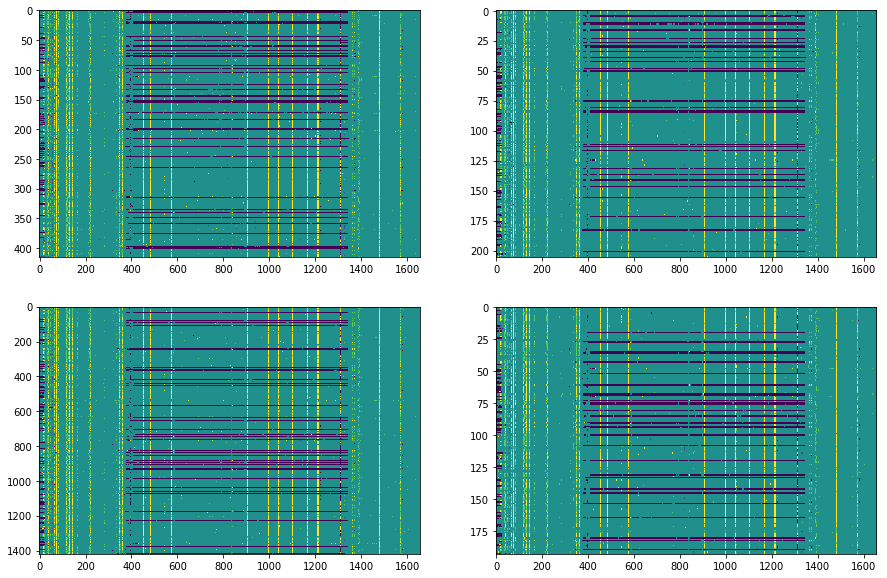

In [466]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
fem_aff_indices = np.where([x in ihart_ind_to_index and ihart_is_child[ihart_ind_to_index[x]] and child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2' for x in sample_ids])[0]
plt.imshow(gen[fem_aff_indices, :], aspect='auto')

plt.subplot(2, 2, 2)
fem_unaff_indices = np.where([x in ihart_ind_to_index and ihart_is_child[ihart_ind_to_index[x]] and child_id_to_sex[x] == '2' and child_id_to_affected[x] == '1' for x in sample_ids])[0]
plt.imshow(gen[fem_unaff_indices, :], aspect='auto')

plt.subplot(2, 2, 3)
male_aff_indices = np.where([x in ihart_ind_to_index and ihart_is_child[ihart_ind_to_index[x]] and child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2' for x in sample_ids])[0]
plt.imshow(gen[male_aff_indices, :], aspect='auto')

plt.subplot(2, 2, 4)
male_unaff_indices = np.where([x in ihart_ind_to_index and ihart_is_child[ihart_ind_to_index[x]] and child_id_to_sex[x] == '1' and child_id_to_affected[x] == '1' for x in sample_ids])[0]
plt.imshow(gen[male_unaff_indices, :], aspect='auto')

plt.show()

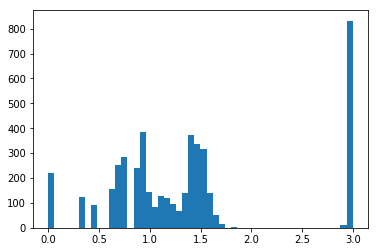

In [467]:
plt.hist(np.log10(np.sum(gen<0, axis=1)+1), bins=50)
plt.show()

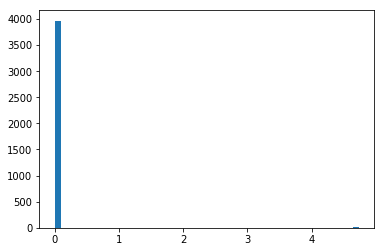

In [468]:
plt.hist(np.log10(np.sum(ihart_deletions==2, axis=1)+1), bins=50)
plt.show()

In [469]:
has_double = np.where(np.sum(gen<0, axis=1)>100)[0]
gen_has_double = set([sample_ids[i] for i in has_double])
has_double = np.where(np.sum(ihart_deletions==2, axis=1)>10000)[0]
del_has_double = set([ihart_individuals[i] for i in has_double])
print(len(gen_has_double), len(del_has_double))

print('Gen is dd, del is not', len((gen_has_double - del_has_double) & set(ihart_individuals)))
print('Gen is dd, del is not, moms', len((gen_has_double - del_has_double) & set([ihart_individuals[i] for i in range(len(ihart_individuals)) if ihart_is_mother[i]])))
print('Gen is dd, del is not, dads', len((gen_has_double - del_has_double) & set([ihart_individuals[i] for i in range(len(ihart_individuals)) if ihart_is_father[i]])))
print('Gen is dd, del is not, children', len((gen_has_double - del_has_double) & set([ihart_individuals[i] for i in range(len(ihart_individuals)) if ihart_is_child[i]])))

print('Del is dd, gen is not', len(del_has_double - gen_has_double))

845 27
Gen is dd, del is not 701
Gen is dd, del is not, moms 155
Gen is dd, del is not, dads 163
Gen is dd, del is not, children 383
Del is dd, gen is not 0


In [470]:
print('Moms', sorted((gen_has_double - del_has_double) & set([ihart_individuals[i] for i in range(len(ihart_individuals)) if ihart_is_mother[i]])))
print('Dads', sorted((gen_has_double - del_has_double) & set([ihart_individuals[i] for i in range(len(ihart_individuals)) if ihart_is_father[i]])))
print('Children', sorted((gen_has_double - del_has_double) & set([ihart_individuals[i] for i in range(len(ihart_individuals)) if ihart_is_child[i]])))



Moms ['AU000101', 'AU002701', 'AU003001', 'AU0093202', 'AU011501', 'AU012701', 'AU015701', 'AU016901', 'AU0178202', 'AU017901', 'AU019701', 'AU019901', 'AU020701', 'AU021001', 'AU023601', 'AU024701', 'AU026701', 'AU028201', 'AU028901', 'AU030601', 'AU0316202', 'AU038601', 'AU041101', 'AU042301', 'AU043001', 'AU048301', 'AU062601', 'AU073701', 'AU073801', 'AU0782202', 'AU080201', 'AU080901', 'AU082801', 'AU083601', 'AU0839202', 'AU0871202', 'AU0897202', 'AU0906202', 'AU0922202', 'AU0923202', 'AU0953202', 'AU0976202', 'AU0979202', 'AU0994202', 'AU0997202', 'AU1005202', 'AU1009202', 'AU1030202', 'AU1067202', 'AU1074202', 'AU1098202', 'AU1099202', 'AU1147202', 'AU1163202', 'AU1187202', 'AU1192202', 'AU1194202', 'AU1195202', 'AU1196202', 'AU1218202', 'AU1227202', 'AU1228202', 'AU1242202', 'AU1255202', 'AU1266202', 'AU1280202', 'AU1309202', 'AU1351202', 'AU1352202', 'AU1357202', 'AU1370202', 'AU1391202', 'AU1399202', 'AU1412202', 'AU1438202', 'AU1445202', 'AU1453202', 'AU1462202', 'AU1466202

KeyError: '0'

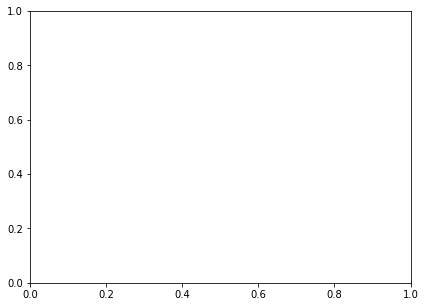

In [471]:
import random

famkey = [k for k, v in fam_to_inds.items() if 'AU0923201' in v][0]
inds = fam_to_inds[famkey]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
indices = [ihart_ind_to_index[x] for x in inds]
plt.imshow(ihart_deletions[indices, :], aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
indices = [sample_id_to_index[x] for x in inds]
plt.imshow(gen[indices, :], aspect='auto', vmin=-1, vmax=2)

plt.show()

In [ ]:
has_double = np.sum(gen<0, axis=1)>100
c = np.zeros((2, 2), dtype=int)
c[0, 0] = np.sum([x in child_id_to_affected and child_id_to_affected[x] == '2' and has_double[i] for i, x in enumerate(sample_ids)])
c[0, 1] = np.sum([x in child_id_to_affected and child_id_to_affected[x] != '2' and has_double[i] for i, x in enumerate(sample_ids)])
c[1, 0] = np.sum([x in child_id_to_affected and child_id_to_affected[x] == '2' and not has_double[i] for i, x in enumerate(sample_ids)])
c[1, 1] = np.sum([x in child_id_to_affected and child_id_to_affected[x] != '2' and not has_double[i] for i, x in enumerate(sample_ids)])
print(c, scipy.stats.chi2_contingency(c)[1])

c = np.zeros((2, 2), dtype=int)
c[0, 0] = np.sum([x in child_id_to_affected and child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2' and has_double[i] for i, x in enumerate(sample_ids)])
c[0, 1] = np.sum([x in child_id_to_affected and child_id_to_sex[x] == '2' and child_id_to_affected[x] != '2' and has_double[i] for i, x in enumerate(sample_ids)])
c[1, 0] = np.sum([x in child_id_to_affected and child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2' and not has_double[i] for i, x in enumerate(sample_ids)])
c[1, 1] = np.sum([x in child_id_to_affected and child_id_to_sex[x] == '2' and child_id_to_affected[x] != '2' and not has_double[i] for i, x in enumerate(sample_ids)])
print(c, scipy.stats.chi2_contingency(c)[1])

c = np.zeros((2, 2), dtype=int)
c[0, 0] = np.sum([x in child_id_to_affected and child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2' and has_double[i] for i, x in enumerate(sample_ids)])
c[0, 1] = np.sum([x in child_id_to_affected and child_id_to_sex[x] == '1' and child_id_to_affected[x] != '2' and has_double[i] for i, x in enumerate(sample_ids)])
c[1, 0] = np.sum([x in child_id_to_affected and child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2' and not has_double[i] for i, x in enumerate(sample_ids)])
c[1, 1] = np.sum([x in child_id_to_affected and child_id_to_sex[x] == '1' and child_id_to_affected[x] != '2' and not has_double[i] for i, x in enumerate(sample_ids)])
print(c, scipy.stats.chi2_contingency(c)[1])

